In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score

import numpy as np
import itertools
import keras
import keras.layers as layers
import tensorflow as tf
import os
from nltk.tokenize import word_tokenize
from tensorflow.keras.layers import TextVectorization

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences


In [2]:
data = pd.read_csv("master_dataset/processed_data.csv")
# drop unwanted features


# Drop all the column , keep only class , overall_context

x = data['overall_content']
y = data['class'] 
    
# As we will be vectorizing the content and doing LSTM on it

print(x,y)

0        donald trump sends out embarrassing new year’s...
1        drunk bragging trump staffer started russian c...
2        sheriff david clarke becomes an internet joke ...
3        trump is so obsessed he even has obama’s name ...
4        pope francis just called out donald trump duri...
                               ...                        
38653    'fully committed' nato backs new us approach a...
38654    lexisnexis withdrew two products chinese marke...
38655    minsk cultural hub becomes authorities in shad...
38656    vatican upbeat possibility pope francis visiti...
38657    indonesia buy $114 billion worth russian jets ...
Name: overall_content, Length: 38658, dtype: object 0        1
1        1
2        1
3        1
4        1
        ..
38653    0
38654    0
38655    0
38656    0
38657    0
Name: class, Length: 38658, dtype: int64


In [3]:
y.value_counts()

0    21196
1    17462
Name: class, dtype: int64

### Prepare the data

In [4]:
#first split the dataset into training and test sets


x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state = 4222)

x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.25, random_state = 4222)

#check that train set is balance
y_train.value_counts()

# Since the dataset is pretty balanced, Real - 55% and Fake - 45% of the data,
# By oversampling, we will have duplicates in the model which will overtrain out model.
# By undersampling, we might lose out on critical information.

0    12717
1    10477
Name: class, dtype: int64

In [5]:
# Find the number of maximum text 
lst = []
words = []
for item in x_train:
    lst.append(len(item.split()))

big_list = [item.split() for item in x_train]
flat_list = [item for sublist in big_list for item in sublist]
unique = list(set(flat_list))


In [6]:
print(len(unique)) # How many different words are there
print(max(lst)) # What the maximum word in an article 

207463
5130


(array([2.1596e+04, 1.4800e+03, 7.0000e+01, 2.4000e+01, 1.2000e+01,
        4.0000e+00, 3.0000e+00, 3.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([2.0000e+00, 5.1480e+02, 1.0276e+03, 1.5404e+03, 2.0532e+03,
        2.5660e+03, 3.0788e+03, 3.5916e+03, 4.1044e+03, 4.6172e+03,
        5.1300e+03]),
 <BarContainer object of 10 artists>)

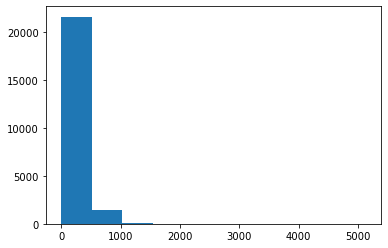

In [7]:
import matplotlib.pyplot as plt
plt.hist(lst)

In [8]:
# # Model constants / Parameters
max_features = 40000
embed_size = 100
maxlen = [250,500,1000]
dense_units = [64,128]
lstm_units = [64,128]

In [9]:
candidate_params = list(itertools.product(maxlen,dense_units,lstm_units))

In [10]:
candidate_params

[(250, 64, 64),
 (250, 64, 128),
 (250, 128, 64),
 (250, 128, 128),
 (500, 64, 64),
 (500, 64, 128),
 (500, 128, 64),
 (500, 128, 128),
 (1000, 64, 64),
 (1000, 64, 128),
 (1000, 128, 64),
 (1000, 128, 128)]

In [11]:
def tokenized_sets(maxlen):
    #result = []
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(x_train.squeeze())

    tokenized_train = tokenizer.texts_to_sequences(x_train.squeeze())
    x_train_tokenized = pad_sequences(tokenized_train , maxlen=maxlen)
    
    tokenized_val = tokenizer.texts_to_sequences(x_validation)
    x_validation_tokenized = pad_sequences(tokenized_val , maxlen=maxlen)
    
    tokenized_test = tokenizer.texts_to_sequences(x_test)
    x_test_tokenized = pad_sequences(tokenized_test , maxlen=maxlen)

    return(x_train_tokenized,x_validation_tokenized,x_test_tokenized)

## Build A model

In [13]:
for i in range(len(candidate_params)):
    maxlen = candidate_params[i][0]
    dense_units = candidate_params[i][1]
    lstm_units = candidate_params[i][2]


    result = tokenized_sets(maxlen)

    x_train_tokenized = result[0]
    x_validation_tokenized = result[1]
    x_test_tokenized = result[2]

    model = keras.models.Sequential()
    model.add(layers.Embedding(max_features,embed_size))
    model.add(layers.Dropout(0.5))

    model.add(layers.LSTM(lstm_units, return_sequences=True))
    model.add(layers.GlobalMaxPooling1D())

    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1,activation="sigmoid",name="predictions"))

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

    print("Max Length: {} , Dense Unit {} , LSTM Unit {}   ".format( candidate_params[i][0], candidate_params[i][1] , candidate_params[i][2]))

    model.fit(x_train_tokenized, y_train,validation_data=(x_validation_tokenized,y_validation))
    

Max Length: 250 , Dense Unit 64 , LSTM Unit 64   
725/725 [==============================] - 117s 158ms/step - loss: 0.1336 - accuracy: 0.9431 - val_loss: 0.0339 - val_accuracy: 0.9893
Max Length: 250 , Dense Unit 64 , LSTM Unit 128   
725/725 [==============================] - 188s 256ms/step - loss: 0.1632 - accuracy: 0.9331 - val_loss: 0.0395 - val_accuracy: 0.9865
Max Length: 250 , Dense Unit 128 , LSTM Unit 64   
725/725 [==============================] - 121s 164ms/step - loss: 0.1634 - accuracy: 0.9267 - val_loss: 0.0380 - val_accuracy: 0.9878
Max Length: 250 , Dense Unit 128 , LSTM Unit 128   
725/725 [==============================] - 179s 245ms/step - loss: 0.1613 - accuracy: 0.9344 - val_loss: 0.0416 - val_accuracy: 0.9869
Max Length: 500 , Dense Unit 64 , LSTM Unit 64   
725/725 [==============================] - 198s 271ms/step - loss: 0.1379 - accuracy: 0.9409 - val_loss: 0.0232 - val_accuracy: 0.9924
Max Length: 500 , Dense Unit 64 , LSTM Unit 128   
725/725 [===========

## Train and evalute the model

In [14]:
result = tokenized_sets(500)

x_train_tokenized = result[0]
x_validation_tokenized = result[1]
x_test_tokenized = result[2]

model = keras.models.Sequential()
model.add(layers.Embedding(max_features,embed_size))
model.add(layers.Dropout(0.5))

model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation="sigmoid",name="predictions"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

model.fit(x_train_tokenized, y_train,validation_data=(x_validation_tokenized,y_validation), epochs=2)

Epoch 1/2
725/725 [==============================] - 280s 383ms/step - loss: 0.1301 - accuracy: 0.9454 - val_loss: 0.0246 - val_accuracy: 0.9916
Epoch 2/2
725/725 [==============================] - 345s 475ms/step - loss: 0.0116 - accuracy: 0.9967 - val_loss: 0.0196 - val_accuracy: 0.9942


In [15]:
# Prediction if the news is fake 
# Class 1 (Fake) if predicted prob >= 0.5, else class 0 (Real)

y_pred = (model.predict(x_test_tokenized) >= 0.5).astype("int")


242/242 [==============================] - 31s 127ms/step


In [16]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4235
           1       1.00      0.99      0.99      3497

    accuracy                           0.99      7732
   macro avg       1.00      0.99      0.99      7732
weighted avg       0.99      0.99      0.99      7732



### Analysis after Training Model

In [17]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train_tokenized,y_train)[1]*100 ,  "%")
print("Accuracy of the model on Validation Data is - " , model.evaluate(x_validation_tokenized,y_validation)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test_tokenized,y_test)[1]*100 , "%")


725/725 [==============================] - 93s 129ms/step - loss: 0.0013 - accuracy: 0.9997
Accuracy of the model on Training Data is -  99.97413158416748 %
242/242 [==============================] - 31s 127ms/step - loss: 0.0196 - accuracy: 0.9942
Accuracy of the model on Validation Data is -  99.41800236701965 %
242/242 [==============================] - 31s 128ms/step - loss: 0.0173 - accuracy: 0.9950
Accuracy of the model on Testing Data is -  99.49560165405273 %
